In [1]:
# import of standard python libraries and the required lenstronomy modules
import numpy as np
import os
import time
import corner
import astropy.io.fits as pyfits
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cms
import matplotlib.ticker as mtick
%matplotlib inline


from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.param_util as param_util
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import kernel_util
import lenstronomy.Util.util as util


from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
import astropy.io.fits as pyfits


In [2]:
def CMD(z1,z2):
    ## This is a function that computes the comoving distance
    ## between two redshifts z1 and z2.
    cosmo = FlatLambdaCDM(H0=70, Om0=0.316) 
    return cosmo.comoving_distance(z2) - cosmo.comoving_distance(z1)
    
def ADD(z1,z2):
    ## This is a function that computes the angular diameter distance
    ## between two redshifts z1 and z2.
    cosmo = FlatLambdaCDM(H0=70, Om0=0.316) 
    return cosmo.angular_diameter_distance_z1z2(z1,z2)

def sigma_cr(zd,zs):
    ## This function calculates the critical surface mass density at
    ## redshift zd, relative to the source redshift zs.
    const = 1.663e18*u.M_sun / u.Mpc##c^2/(4 pi G)
    return const*(ADD(0,zs)/(ADD(zd,zs)*ADD(0,zd))) ##in units Msun/Mpc^2

def gfunc(c):
    ## This is the g(c) function that is defined
    ## commonly in NFW profiles.
    a = np.log(1.+c) - (c/(1.+c))
    return 1./a

def rs_angle(zd,rs): 
    ##takes in interloper redshift, scale redius, gives you the scale redius in angular units
    Dd = ADD(0,zd)
    rs_mpc = rs*u.Mpc
    return ((1./4.848e-6)*rs_mpc)/Dd ##gives in arcsec

def alpha_s(m,rs,zd,zs):
    ##takes in subhalo mass, scale radius, interloper redshift, source redshift
    ##returns the angular deflection at scale radius
    Dd = ADD(0,zd)
    m_msun = m*u.M_sun
    rs_mpc = rs*u.Mpc
    con = (1./np.pi)*gfunc(200.)*(1.-np.log(2))
    return (1/4.848e-6)*(con*m_msun)/((rs_mpc*Dd)*sigma_cr(zd,zs))


def k_ext(N,m,A,zd,zs,pixsize):
    ## FOR NOW THIS IS SET TO ZERO BECAUSE I CAN'T GET IT TO WORK
    m_msun = m*u.M_sun
    A_mpc2 = (pixsize**4)*(ADD(0.,zd)**2.)*A*((4.848e-6)**2.)  ##arcsec conversion
    return 0.##-(N*m_msun)/(A_mpc2*sigma_cr(zd,zs))

def xi_to_x(xi,z):
    ##takes in physical coordinates (Mpc), turns it into angular coordinates (arcsec)
    x = np.array(((xi*u.Mpc)/ADD(0.,z))/4.848e-6)
    y = x.astype(np.float)
    return y

def x_to_xi(x,z):
    ##takes in angular coordinates (arcsec), turns it into physical coordinates (Mpc)
    return ((x*4.848e-6)*ADD(0,z))/u.Mpc

def xi_to_pix(xi,z,pixsize,pixnum):
    return (xi_to_x(xi,z))/pixsize + pixnum/2.


def rein(M,zl,zs):
    ## calculates Einstein radius
    A = ((M/10.**11.09)**0.5)*((ADD(zl,zs)/(ADD(0,zl)*(ADD(0,zs))))*(1000*u.Mpc))**0.5
    return A


def xi_back_proj(xi,zd,zl,zs):
    ### projecting the background interlopers onto the lens plane
    return xi*((1.+zd)/(1.+zl))*(CMD(zl,zs)/CMD(zd,zs))

In [3]:
### let us define a function that will create the things we need taking in a imagesz
def imstats(imagesz):
    minbin = 0.
    maxbin = 1000.
    numbin = 200
    
    
    shp = np.shape(imagesz)
    im0 = imagesz[0][0]## the first image is the massless one
    imsub = imagesz[int(shp[0]/5)]##this is the one with substructure
    
    his0,binz0, _ = pixhist(im0,minbin,maxbin,numbin)
    diffss = []
    stdss = []
    meanss = []
    sqrmeanss = []
    
    hissqrmeanses = []
    hisses = []
    for i in range(shp[0]):
        hiss = []
        hissqrmeans = []
        
        diffs = []
        stds = []
        means = []
        sqrmeans = []
        for j in range(shp[1]):
            hisa,binza, _ = pixhist(imagesz[i][j],minbin,maxbin,numbin)
            hisdiff = (hisa - his0)**2.
            hissqrmeans.append(np.mean(hisdiff))
            hiss.append(hisdiff)
            
            diff = imagesz[i][j] - im0
            
            difshp = np.shape(diff)
            ##### masking the center pixels
            SM = 10#### mask size
            
            for l in range(difshp[0]):
                for k in range(difshp[1]):
                    metric = (l - (difshp[0]/2.)- 0.5)**2. + (k - (difshp[1]/2.-0.5))**2.  
                    if metric < SM:
                        diff[l][k] = 0#None
                        
            
            stds.append(np.std(diff))
            means.append(np.mean(diff))
            sqrmeans.append(np.mean(diff**2.))
            diffs.append(diff)
            
        hisses.append(hiss)
        hissqrmeanses.append(hissqrmeans)
        
        diffss.append(diffs)
        stdss.append(stds)
        meanss.append(means)
        sqrmeanss.append(sqrmeans)
    ##stdss is the standard deviation of the residue
    ##meanss is the mean of the residue
    ##sqrmean is the square mean of the residue
    ##diffss are the residue maps
    ##hisses are the pixel value histograms
    ##hisssqrmeanses is the histogram residue mean squares
    return stdss,meanss,sqrmeanss,diffss,hisses,hissqrmeanses


def pixhist(image,minbin,maxbin,numbin):
    flatt = np.ndarray.flatten(image)
    bins = np.linspace(minbin,maxbin,numbin+1)
    his,binz = np.histogram(image,bins)
    return his,binz,flatt


### let us define a function that will create the things we need taking in a imagesz
def imdiff(imagesz,imagesz0):
    minbin = 0.
    maxbin = 1000.
    numbin = 200
    
    
    shp = np.shape(imagesz)

    diffss = []
    stdss = []
    meanss = []
    sqrmeanss = []
    
    hissqrmeanses = []
    hisses = []
    for i in range(shp[0]):
        hiss = []
        hissqrmeans = []
        
        diffs = []
        stds = []
        means = []
        sqrmeans = []
        for j in range(shp[1]):
            hisa,binza, _ = pixhist(imagesz[i][j],minbin,maxbin,numbin)
            his0,binz0, _ = pixhist(imagesz0[i][j],minbin,maxbin,numbin)
            hisdiff = (hisa - his0)**2.
            hissqrmeans.append(np.mean(hisdiff))
            hiss.append(hisdiff)
            
            diff = imagesz[i][j] - imagesz0[i][j]
            
            difshp = np.shape(diff)
            ##### masking the center pixels
            SM = 10#### mask size
            
            for l in range(difshp[0]):
                for k in range(difshp[1]):
                    metric = (l - (difshp[0]/2.)- 0.5)**2. + (k - (difshp[1]/2.-0.5))**2.  
                    if metric < SM:
                        diff[l][k] = 0#None
                        
            
            stds.append(np.std(diff))
            means.append(np.mean(diff))
            sqrmeans.append(np.mean(diff**2.))
            diffs.append(diff)
            
        hisses.append(hiss)
        hissqrmeanses.append(hissqrmeans)
        
        diffss.append(diffs)
        stdss.append(stds)
        meanss.append(means)
        sqrmeanss.append(sqrmeans)
    ##stdss is the standard deviation of the residue
    ##meanss is the mean of the residue
    ##sqrmean is the square mean of the residue
    ##diffss are the residue maps
    ##hisses are the pixel value histograms
    ##hisssqrmeanses is the histogram residue mean squares
    return stdss,meanss,sqrmeanss,diffss,hisses,hissqrmeanses

/home/cagansengul/anaconda2/envs/lensing/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


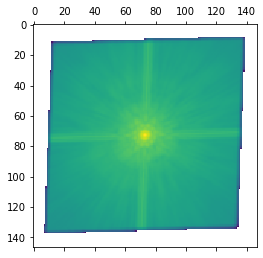

In [4]:
# define lens configuration and cosmology (not for lens modelling)
z_lens = 0.2
z_source = 1.0
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)


# import PSF file
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
psf_filename = os.path.join(module_path, 'Dropbox/psf_example.fits')
kernel = pyfits.getdata(psf_filename)

plt.matshow(np.log10(kernel))
plt.show()

    
# data specifics
background_rms = .01  #  background noise per pixel (Gaussian rms value)
exp_time = 80.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 80  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.1  # full width half max of PSF (only valid when psf_type='gaussian')
psf_type = 'PIXEL'  # 'gaussian', 'pixel', 'NONE'
kernel_size = 91  # PSF kernel size (odd number required).


# initial input simulation
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kernel_cut = kernel_util.cut_psf(kernel, kernel_size)
kwargs_psf = {'psf_type': psf_type, 'fwhm': fwhm, 'pixel_size': deltaPix, 'kernel_point_source': kernel_cut}
psf_class = PSF(**kwargs_psf)

In [5]:
z_min = 0.05
z_max = z_source-z_min
Nit = 50



## INTERLOPER PROPERTIES ########################################################################### 
N = 1##Number of perturbers
M = 30 ##Averaging different realizations

m_int = 1e9 ##interloper mass

t_e = 0.02 ##interloper einstein radius at lens redshift

disc_size = 2. ##  interlopers are randomly distributed to a disk that is this
               ##  this times bigger than the einstein radius of the lens
    
    
theta_E = 1.16
r2s = ((disc_size*x_to_xi(theta_E,z_lens))**2.)*(np.random.rand(N,M))
rss = np.sqrt(r2s)
theta_p = 2*np.pi*(np.random.rand(N,M))
xs = rss*np.cos(theta_p)
ys = rss*np.sin(theta_p)
xpixs = np.zeros([Nit,N,M])
ypixs = np.zeros([Nit,N,M])

zls = np.linspace(z_min,z_max,Nit)

In [6]:
imagesz = [] 

for i in range(Nit):
    print(i)
    z_point = zls[i]
    
    
    imagesM = []  ## this is a sub-list of imagesz that will be of shape (Number of statistics,x-Pix,y-Pix)
    
    xpixs[i] = xi_to_pix(xs,zls[i],deltaPix,numPix)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
    ypixs[i] = xi_to_pix(ys,zls[i],deltaPix,numPix)
    
    
    point_x = xi_to_x(xs,z_point)
    point_y = xi_to_x(ys,z_point)
    
    for k in range(M):
    
        # lensing quantities
        kwargs_shear = {'e1': 0.0, 'e2': -0.05}  # shear values to the source plane
        kwargs_spemd = {'theta_E': theta_E, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}# parameters of the deflector lens model

        rs = 0.001
        rsang = float(rs_angle(z_point,rs))
        
        m = m_int
        if i == 0:
            m = 0.
        alphars = float(alpha_s(m,rs,z_point,z_source))
        
        kwargs_point = []
        for j in range(N):
            kwargs_point.append({'Rs':rsang,'alpha_Rs':alphars, 'center_x':point_x[j][k] , 'center_y': point_y[j][k]})
        
        # the lens model is a supperposition of an elliptical lens model with external shear


        if z_point >= z_lens:
            lens_model_list = ['SPEMD', 'SHEAR']+['NFW' for i in range(int(N))]
            kwargs_lens = [kwargs_spemd, kwargs_shear]+[kwargs_point[i] for i in range(int(N))]
            redshift_list = [z_lens,z_lens]+[z_point for i in range(int(N))]
            
        if z_point <= z_lens:
            lens_model_list = ['NFW' for i in range(int(N))]+['SPEMD', 'SHEAR']
            kwargs_lens = [kwargs_point[i] for i in range(int(N))]+[kwargs_spemd, kwargs_shear]
            redshift_list = [z_point for i in range(int(N))]+[z_lens,z_lens]
        

        lens_model_class = LensModel(lens_model_list=lens_model_list,
                                     z_source=z_source, lens_redshift_list=redshift_list, multi_plane=True)

        # choice of source type
        source_x = 0.3
        source_y = 0.1


        # Sersic parameters in the initial simulation
        phi_G, q = 0.5, 0.8
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
        #kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
        source_model_list = ['SERSIC_ELLIPSE']
        kwargs_source = [kwargs_sersic_source]
        source_model_class = LightModel(light_model_list=source_model_list)


        # lens light model
        phi_G, q = 0.9, 0.9
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
        lens_light_model_list = ['SERSIC_ELLIPSE']
        kwargs_lens_light = [kwargs_sersic_lens]
        lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


        kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

        imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                        lens_light_model_class, kwargs_numerics=kwargs_numerics)

        # generate image
        image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
        poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
        bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
        image_sim = image_sim #+ bkg + poisson
        
        

        kwargs_data['image_data'] = image_sim
        data_class.update_data(image_sim)
        
        imagesM.append(image_sim)
    imagesz.append(imagesM)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [7]:
imagesz_proj1 = []  ## one sided projection with no mass mod

lensed_point_x = np.zeros([N,M])
lensed_point_y = np.zeros([N,M])

for i in range(Nit):
    print(i)
    z_point = zls[i]
    
    
    imagesM = []  ## this is a sub-list of imagesz that will be of shape (Number of statistics,x-Pix,y-Pix)
    
    xpixs[i] = xi_to_pix(xs,zls[i],deltaPix,numPix)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
    ypixs[i] = xi_to_pix(ys,zls[i],deltaPix,numPix)
    
    for k in range(M):
    
        # lensing quantities
        kwargs_shear = {'e1': 0.0, 'e2': -0.05}  # shear values to the source plane
        kwargs_spemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

        point_x = xi_to_x(xs,z_point)
        point_y = xi_to_x(ys,z_point)
        theta_e_new = t_e#0.#float(theta_Eproj(t_e,z_lens,zls[i],z_source))
        kwargs_point = []

        
        # the lens model is a supperposition of an elliptical lens model with external shear

        
        ### Calculating the lensed position of the interlopers if they are behind
        
        lens_model_list_smooth = ['SPEMD', 'SHEAR']#+['POINT_MASS' for i in range(int(N))]
        kwargs_lens_smooth = [kwargs_spemd, kwargs_shear]#+[kwargs_point[i] for i in range(int(N))]
        redshift_list_smooth = [z_lens,z_lens]
        
        #print(z_point,z_lens)
        if False:#z_point > z_lens:
            lens_model_class_smooth = LensModel(lens_model_list=lens_model_list_smooth,
                                         z_source = z_point, lens_redshift_list=redshift_list_smooth,
                                         multi_plane=True)
            


            solver = LensEquationSolver(lens_model_class_smooth)
            for j in range(N):
                x_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[0]
                y_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[1]
                argmag = np.argmax(np.abs(solver.lensModel.magnification(x_mins, y_mins, kwargs_lens_smooth)))
                #print(point_x[j][k] ,point_y[j][k],'        ',solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth))
                #print(j,N)
                #print(point_x[j][k])
                lensed_point_x[j][k], lensed_point_y[j][k] = x_mins[0],y_mins[0] ##first one always max
                #solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
   
        else:
            for j in range(N):
                lensed_point_x[j][k], lensed_point_y[j][k] = point_x[j][k] , point_y[j][k]
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
            


        rs = 0.001
        rsang = float(rs_angle(z_point,rs))
        
        m = m_int
        if i == 0:
            m = 0.
        alphars = float(alpha_s(m,rs,z_point,z_source))

        for j in range(N):
            kwargs_point.append({'Rs':rsang,'alpha_Rs':alphars,
                                 'center_x':lensed_point_x[j][k] , 
                                 'center_y': lensed_point_y[j][k]}) 

            
            
        #z_point = z_lens  
            
        if z_point >= z_lens:
            lens_model_list = ['SPEMD', 'SHEAR']+['NFW' for i in range(int(N))]
            kwargs_lens = [kwargs_spemd, kwargs_shear]+[kwargs_point[i] for i in range(int(N))]
            redshift_list = [z_lens,z_lens]+[z_lens for i in range(int(N))]
            
        if z_point < z_lens:
            lens_model_list = ['NFW' for i in range(int(N))]+['SPEMD', 'SHEAR']
            kwargs_lens = [kwargs_point[i] for i in range(int(N))]+[kwargs_spemd, kwargs_shear]
            redshift_list = [z_lens for i in range(int(N))]+[z_lens,z_lens]
        

        lens_model_class = LensModel(lens_model_list=lens_model_list,
                                     z_source=z_source, lens_redshift_list=redshift_list,
                                     multi_plane=True)

        # choice of source type
        source_x = 0.3
        source_y = 0.1


        # Sersic parameters in the initial simulation
        phi_G, q = 0.5, 0.8
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
        #kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
        source_model_list = ['SERSIC_ELLIPSE']
        kwargs_source = [kwargs_sersic_source]
        source_model_class = LightModel(light_model_list=source_model_list)


        # lens light model
        phi_G, q = 0.9, 0.9
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
        lens_light_model_list = ['SERSIC_ELLIPSE']
        kwargs_lens_light = [kwargs_sersic_lens]
        lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


        kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

        imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                        lens_light_model_class, kwargs_numerics=kwargs_numerics)

        # generate image
        image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
        poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
        bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
        image_sim = image_sim #+ bkg + poisson
        
        

        kwargs_data['image_data'] = image_sim
        data_class.update_data(image_sim)
        
        imagesM.append(image_sim)
    imagesz_proj1.append(imagesM)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [8]:
imagesz_proj2 = []  ### 2 sided projection with no mass modification

lensed_point_x = np.zeros([N,M])
lensed_point_y = np.zeros([N,M])

for i in range(Nit):
    print(i)
    z_point = zls[i]
    
    
    imagesM = []  ## this is a sub-list of imagesz that will be of shape (Number of statistics,x-Pix,y-Pix)
    
    xpixs[i] = xi_to_pix(xs,zls[i],deltaPix,numPix)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
    ypixs[i] = xi_to_pix(ys,zls[i],deltaPix,numPix)
    
    for k in range(M):
    
        # lensing quantities
        kwargs_shear = {'e1': 0.0, 'e2': -0.05}  # shear values to the source plane
        kwargs_spemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

        point_x = xi_to_x(xs,z_point)
        point_y = xi_to_x(ys,z_point)
        
        theta_e_new = t_e#0.#float(theta_Eproj(t_e,z_lens,zls[i],z_source))
        kwargs_point = []

        
        # the lens model is a supperposition of an elliptical lens model with external shear

        
        ### Calculating the lensed position of the interlopers if they are behind
        
        lens_model_list_smooth = ['SPEMD', 'SHEAR']#+['POINT_MASS' for i in range(int(N))]
        kwargs_lens_smooth = [kwargs_spemd, kwargs_shear]#+[kwargs_point[i] for i in range(int(N))]
        redshift_list_smooth = [z_lens,z_lens]
        
        #print(z_point,z_lens)
        if z_point > z_lens:
            lensed_point_x[j][k] = xi_to_x(xi_back_proj(x_to_xi(point_x[j][k],z_point),z_point,z_lens,z_source),z_lens)
            lensed_point_y[j][k] = xi_to_x(xi_back_proj(x_to_xi(point_y[j][k],z_point),z_point,z_lens,z_source),z_lens)
            '''
            lens_model_class_smooth = LensModel(lens_model_list=lens_model_list_smooth,
                                         z_source = z_point, lens_redshift_list=redshift_list_smooth,
                                         multi_plane=True)
            


            solver = LensEquationSolver(lens_model_class_smooth)
            for j in range(N):
                x_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[0]
                y_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[1]
                argmag = np.argmax(np.abs(solver.lensModel.magnification(x_mins, y_mins, kwargs_lens_smooth)))
                #print(point_x[j][k] ,point_y[j][k],'        ',solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth))
                #print(j,N)
                #print(point_x[j][k])
                lensed_point_x[j][k], lensed_point_y[j][k] = x_mins[0],y_mins[0] ##first one always max
                #solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
            '''
   
        else:
            for j in range(N):
                lensed_point_x[j][k], lensed_point_y[j][k] = point_x[j][k] , point_y[j][k]
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
            


        rs = 0.001
        rsang = float(rs_angle(z_point,rs))
        
        m = m_int#*((sigma_cr(z_point,z_source)/sigma_cr(z_lens,z_source))**2.)
        if i == 0:
            m = 0.
        alphars = float(alpha_s(m,rs,z_point,z_source))

        for j in range(N):
            kwargs_point.append({'Rs':rsang,'alpha_Rs':alphars,
                                 'center_x':lensed_point_x[j][k] , 
                                 'center_y': lensed_point_y[j][k]}) 

            
            
        #z_point = z_lens  
            
        if z_point >= z_lens:
            lens_model_list = ['SPEMD', 'SHEAR']+['NFW' for i in range(int(N))]
            kwargs_lens = [kwargs_spemd, kwargs_shear]+[kwargs_point[i] for i in range(int(N))]
            redshift_list = [z_lens,z_lens]+[z_lens for i in range(int(N))]
            
        if z_point < z_lens:
            lens_model_list = ['NFW' for i in range(int(N))]+['SPEMD', 'SHEAR']
            kwargs_lens = [kwargs_point[i] for i in range(int(N))]+[kwargs_spemd, kwargs_shear]
            redshift_list = [z_lens for i in range(int(N))]+[z_lens,z_lens]
        

        lens_model_class = LensModel(lens_model_list=lens_model_list,
                                     z_source=z_source, lens_redshift_list=redshift_list,
                                     multi_plane=True)

        # choice of source type
        source_x = 0.3
        source_y = 0.1


        # Sersic parameters in the initial simulation
        phi_G, q = 0.5, 0.8
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
        #kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
        source_model_list = ['SERSIC_ELLIPSE']
        kwargs_source = [kwargs_sersic_source]
        source_model_class = LightModel(light_model_list=source_model_list)


        # lens light model
        phi_G, q = 0.9, 0.9
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
        lens_light_model_list = ['SERSIC_ELLIPSE']
        kwargs_lens_light = [kwargs_sersic_lens]
        lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


        kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

        imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                        lens_light_model_class, kwargs_numerics=kwargs_numerics)

        # generate image
        image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
        poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
        bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
        image_sim = image_sim #+ bkg + poisson
        
        

        kwargs_data['image_data'] = image_sim
        data_class.update_data(image_sim)
        
        imagesM.append(image_sim)
    imagesz_proj2.append(imagesM)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [9]:
imagesz_proj3 = []  ### 2 sided projection with no mass modification

lensed_point_x = np.zeros([N,M])
lensed_point_y = np.zeros([N,M])

for i in range(Nit):
    print(i)
    z_point = zls[i]
    
    
    imagesM = []  ## this is a sub-list of imagesz that will be of shape (Number of statistics,x-Pix,y-Pix)
    
    xpixs[i] = xi_to_pix(xs,zls[i],deltaPix,numPix)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
    ypixs[i] = xi_to_pix(ys,zls[i],deltaPix,numPix)
    
    for k in range(M):
    
        # lensing quantities
        kwargs_shear = {'e1': 0.0, 'e2': -0.05}  # shear values to the source plane
        kwargs_spemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

        point_x = xi_to_x(xs,z_point)
        point_y = xi_to_x(ys,z_point)
        
        theta_e_new = t_e#0.#float(theta_Eproj(t_e,z_lens,zls[i],z_source))
        kwargs_point = []

        
        # the lens model is a supperposition of an elliptical lens model with external shear

        
        ### Calculating the lensed position of the interlopers if they are behind
        
        lens_model_list_smooth = ['SPEMD', 'SHEAR']#+['POINT_MASS' for i in range(int(N))]
        kwargs_lens_smooth = [kwargs_spemd, kwargs_shear]#+[kwargs_point[i] for i in range(int(N))]
        redshift_list_smooth = [z_lens,z_lens]
        
        #print(z_point,z_lens)
        if z_point > z_lens:
            lensed_point_x[j][k] = xi_to_x(xi_back_proj(x_to_xi(point_x[j][k],z_point),z_point,z_lens,z_source),z_lens)
            lensed_point_y[j][k] = xi_to_x(xi_back_proj(x_to_xi(point_y[j][k],z_point),z_point,z_lens,z_source),z_lens)
            '''
            lens_model_class_smooth = LensModel(lens_model_list=lens_model_list_smooth,
                                         z_source = z_point, lens_redshift_list=redshift_list_smooth,
                                         multi_plane=True)
            


            solver = LensEquationSolver(lens_model_class_smooth)
            for j in range(N):
                x_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[0]
                y_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[1]
                argmag = np.argmax(np.abs(solver.lensModel.magnification(x_mins, y_mins, kwargs_lens_smooth)))
                #print(point_x[j][k] ,point_y[j][k],'        ',solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth))
                #print(j,N)
                #print(point_x[j][k])
                lensed_point_x[j][k], lensed_point_y[j][k] = x_mins[0],y_mins[0] ##first one always max
                #solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
            '''
   
        else:
            for j in range(N):
                lensed_point_x[j][k], lensed_point_y[j][k] = point_x[j][k] , point_y[j][k]
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
            


        rs = 0.001
        rsang = float(rs_angle(z_point,rs))
        
        if z_point >= z_lens:
            masscoeff = ((z_source-z_point)/(z_source - z_lens))
        if z_point < z_lens:
            masscoeff = (z_point/z_lens)
        
        m = m_int*masscoeff
        if i == 0:
            m = 0.
        alphars = float(alpha_s(m,rs,z_point,z_source))

        for j in range(N):
            kwargs_point.append({'Rs':rsang,'alpha_Rs':alphars,
                                 'center_x':lensed_point_x[j][k] , 
                                 'center_y': lensed_point_y[j][k]}) 

            
            
        #z_point = z_lens  
            
        if z_point >= z_lens:
            lens_model_list = ['SPEMD', 'SHEAR']+['NFW' for i in range(int(N))]
            kwargs_lens = [kwargs_spemd, kwargs_shear]+[kwargs_point[i] for i in range(int(N))]
            redshift_list = [z_lens,z_lens]+[z_lens for i in range(int(N))]
            
        if z_point < z_lens:
            lens_model_list = ['NFW' for i in range(int(N))]+['SPEMD', 'SHEAR']
            kwargs_lens = [kwargs_point[i] for i in range(int(N))]+[kwargs_spemd, kwargs_shear]
            redshift_list = [z_lens for i in range(int(N))]+[z_lens,z_lens]
        

        lens_model_class = LensModel(lens_model_list=lens_model_list,
                                     z_source=z_source, lens_redshift_list=redshift_list,
                                     multi_plane=True)

        # choice of source type
        source_x = 0.3
        source_y = 0.1


        # Sersic parameters in the initial simulation
        phi_G, q = 0.5, 0.8
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
        #kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
        source_model_list = ['SERSIC_ELLIPSE']
        kwargs_source = [kwargs_sersic_source]
        source_model_class = LightModel(light_model_list=source_model_list)


        # lens light model
        phi_G, q = 0.9, 0.9
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
        lens_light_model_list = ['SERSIC_ELLIPSE']
        kwargs_lens_light = [kwargs_sersic_lens]
        lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


        kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

        imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                        lens_light_model_class, kwargs_numerics=kwargs_numerics)

        # generate image
        image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
        poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
        bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
        image_sim = image_sim #+ bkg + poisson
        
        

        kwargs_data['image_data'] = image_sim
        data_class.update_data(image_sim)
        
        imagesM.append(image_sim)
    imagesz_proj3.append(imagesM)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [10]:
imagesz_proj4 = []  ### 2 sided projection with no mass modification

lensed_point_x = np.zeros([N,M])
lensed_point_y = np.zeros([N,M])

for i in range(Nit):
    print(i)
    z_point = zls[i]
    
    
    imagesM = []  ## this is a sub-list of imagesz that will be of shape (Number of statistics,x-Pix,y-Pix)
    
    xpixs[i] = xi_to_pix(xs,zls[i],deltaPix,numPix)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
    ypixs[i] = xi_to_pix(ys,zls[i],deltaPix,numPix)
    
    for k in range(M):
    
        # lensing quantities
        kwargs_shear = {'e1': 0.0, 'e2': -0.05}  # shear values to the source plane
        kwargs_spemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

        point_x = xi_to_x(xs,z_point)
        point_y = xi_to_x(ys,z_point)
        
        theta_e_new = t_e#0.#float(theta_Eproj(t_e,z_lens,zls[i],z_source))
        kwargs_point = []

        
        # the lens model is a supperposition of an elliptical lens model with external shear

        
        ### Calculating the lensed position of the interlopers if they are behind
        
        lens_model_list_smooth = ['SPEMD', 'SHEAR']#+['POINT_MASS' for i in range(int(N))]
        kwargs_lens_smooth = [kwargs_spemd, kwargs_shear]#+[kwargs_point[i] for i in range(int(N))]
        redshift_list_smooth = [z_lens,z_lens]
        
        #print(z_point,z_lens)
        if z_point > z_lens:
            lensed_point_x[j][k] = xi_to_x(xi_back_proj(x_to_xi(point_x[j][k],z_point),z_point,z_lens,z_source),z_lens)
            lensed_point_y[j][k] = xi_to_x(xi_back_proj(x_to_xi(point_y[j][k],z_point),z_point,z_lens,z_source),z_lens)
            '''
            lens_model_class_smooth = LensModel(lens_model_list=lens_model_list_smooth,
                                         z_source = z_point, lens_redshift_list=redshift_list_smooth,
                                         multi_plane=True)
            


            solver = LensEquationSolver(lens_model_class_smooth)
            for j in range(N):
                x_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[0]
                y_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[1]
                argmag = np.argmax(np.abs(solver.lensModel.magnification(x_mins, y_mins, kwargs_lens_smooth)))
                #print(point_x[j][k] ,point_y[j][k],'        ',solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth))
                #print(j,N)
                #print(point_x[j][k])
                lensed_point_x[j][k], lensed_point_y[j][k] = x_mins[0],y_mins[0] ##first one always max
                #solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
            '''
   
        else:
            for j in range(N):
                lensed_point_x[j][k], lensed_point_y[j][k] = point_x[j][k] , point_y[j][k]
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
            


        rs = 0.001
        rsang = float(rs_angle(z_point,rs))
        
        if z_point >= z_lens:
            masscoeff = ((z_source-z_point)/(z_source - z_lens))**0.8
        if z_point < z_lens:
            masscoeff = (z_point/z_lens)**0.8
        
        m = m_int*masscoeff
        if i == 0:
            m = 0.
        alphars = float(alpha_s(m,rs,z_point,z_source))

        for j in range(N):
            kwargs_point.append({'Rs':rsang,'alpha_Rs':alphars,
                                 'center_x':lensed_point_x[j][k] , 
                                 'center_y': lensed_point_y[j][k]}) 

            
            
        #z_point = z_lens  
            
        if z_point >= z_lens:
            lens_model_list = ['SPEMD', 'SHEAR']+['NFW' for i in range(int(N))]
            kwargs_lens = [kwargs_spemd, kwargs_shear]+[kwargs_point[i] for i in range(int(N))]
            redshift_list = [z_lens,z_lens]+[z_lens for i in range(int(N))]
            
        if z_point < z_lens:
            lens_model_list = ['NFW' for i in range(int(N))]+['SPEMD', 'SHEAR']
            kwargs_lens = [kwargs_point[i] for i in range(int(N))]+[kwargs_spemd, kwargs_shear]
            redshift_list = [z_lens for i in range(int(N))]+[z_lens,z_lens]
        

        lens_model_class = LensModel(lens_model_list=lens_model_list,
                                     z_source=z_source, lens_redshift_list=redshift_list,
                                     multi_plane=True)

        # choice of source type
        source_x = 0.3
        source_y = 0.1


        # Sersic parameters in the initial simulation
        phi_G, q = 0.5, 0.8
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
        #kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
        source_model_list = ['SERSIC_ELLIPSE']
        kwargs_source = [kwargs_sersic_source]
        source_model_class = LightModel(light_model_list=source_model_list)


        # lens light model
        phi_G, q = 0.9, 0.9
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
        lens_light_model_list = ['SERSIC_ELLIPSE']
        kwargs_lens_light = [kwargs_sersic_lens]
        lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


        kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

        imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                        lens_light_model_class, kwargs_numerics=kwargs_numerics)

        # generate image
        image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
        poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
        bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
        image_sim = image_sim #+ bkg + poisson
        
        

        kwargs_data['image_data'] = image_sim
        data_class.update_data(image_sim)
        
        imagesM.append(image_sim)
    imagesz_proj4.append(imagesM)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [11]:
imagesz_proj5 = []  ### 2 sided projection with no mass modification

lensed_point_x = np.zeros([N,M])
lensed_point_y = np.zeros([N,M])

for i in range(Nit):
    print(i)
    z_point = zls[i]
    
    
    imagesM = []  ## this is a sub-list of imagesz that will be of shape (Number of statistics,x-Pix,y-Pix)
    
    xpixs[i] = xi_to_pix(xs,zls[i],deltaPix,numPix)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
    ypixs[i] = xi_to_pix(ys,zls[i],deltaPix,numPix)
    
    for k in range(M):
    
        # lensing quantities
        kwargs_shear = {'e1': 0.0, 'e2': -0.05}  # shear values to the source plane
        kwargs_spemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

        point_x = xi_to_x(xs,z_point)
        point_y = xi_to_x(ys,z_point)
        
        theta_e_new = t_e#0.#float(theta_Eproj(t_e,z_lens,zls[i],z_source))
        kwargs_point = []

        
        # the lens model is a supperposition of an elliptical lens model with external shear

        
        ### Calculating the lensed position of the interlopers if they are behind
        
        lens_model_list_smooth = ['SPEMD', 'SHEAR']#+['POINT_MASS' for i in range(int(N))]
        kwargs_lens_smooth = [kwargs_spemd, kwargs_shear]#+[kwargs_point[i] for i in range(int(N))]
        redshift_list_smooth = [z_lens,z_lens]
        
        #print(z_point,z_lens)
        if z_point > z_lens:
            lensed_point_x[j][k] = xi_to_x(xi_back_proj(x_to_xi(point_x[j][k],z_point),z_point,z_lens,z_source),z_lens)
            lensed_point_y[j][k] = xi_to_x(xi_back_proj(x_to_xi(point_y[j][k],z_point),z_point,z_lens,z_source),z_lens)
            '''
            lens_model_class_smooth = LensModel(lens_model_list=lens_model_list_smooth,
                                         z_source = z_point, lens_redshift_list=redshift_list_smooth,
                                         multi_plane=True)
            


            solver = LensEquationSolver(lens_model_class_smooth)
            for j in range(N):
                x_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[0]
                y_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[1]
                argmag = np.argmax(np.abs(solver.lensModel.magnification(x_mins, y_mins, kwargs_lens_smooth)))
                #print(point_x[j][k] ,point_y[j][k],'        ',solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth))
                #print(j,N)
                #print(point_x[j][k])
                lensed_point_x[j][k], lensed_point_y[j][k] = x_mins[0],y_mins[0] ##first one always max
                #solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
            '''
   
        else:
            for j in range(N):
                lensed_point_x[j][k], lensed_point_y[j][k] = point_x[j][k] , point_y[j][k]
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
            


        rs = 0.001
        rsang = float(rs_angle(z_point,rs))
        
        if z_point >= z_lens:
            masscoeff = ((z_source-z_point)/(z_source - z_lens))**0.6
        if z_point < z_lens:
            masscoeff = (z_point/z_lens)**0.6
        
        m = m_int*masscoeff
        if i == 0:
            m = 0.
        alphars = float(alpha_s(m,rs,z_point,z_source))

        for j in range(N):
            kwargs_point.append({'Rs':rsang,'alpha_Rs':alphars,
                                 'center_x':lensed_point_x[j][k] , 
                                 'center_y': lensed_point_y[j][k]}) 

            
            
        #z_point = z_lens  
            
        if z_point >= z_lens:
            lens_model_list = ['SPEMD', 'SHEAR']+['NFW' for i in range(int(N))]
            kwargs_lens = [kwargs_spemd, kwargs_shear]+[kwargs_point[i] for i in range(int(N))]
            redshift_list = [z_lens,z_lens]+[z_lens for i in range(int(N))]
            
        if z_point < z_lens:
            lens_model_list = ['NFW' for i in range(int(N))]+['SPEMD', 'SHEAR']
            kwargs_lens = [kwargs_point[i] for i in range(int(N))]+[kwargs_spemd, kwargs_shear]
            redshift_list = [z_lens for i in range(int(N))]+[z_lens,z_lens]
        

        lens_model_class = LensModel(lens_model_list=lens_model_list,
                                     z_source=z_source, lens_redshift_list=redshift_list,
                                     multi_plane=True)

        # choice of source type
        source_x = 0.3
        source_y = 0.1


        # Sersic parameters in the initial simulation
        phi_G, q = 0.5, 0.8
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
        #kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
        source_model_list = ['SERSIC_ELLIPSE']
        kwargs_source = [kwargs_sersic_source]
        source_model_class = LightModel(light_model_list=source_model_list)


        # lens light model
        phi_G, q = 0.9, 0.9
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
        lens_light_model_list = ['SERSIC_ELLIPSE']
        kwargs_lens_light = [kwargs_sersic_lens]
        lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


        kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

        imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                        lens_light_model_class, kwargs_numerics=kwargs_numerics)

        # generate image
        image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
        poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
        bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
        image_sim = image_sim #+ bkg + poisson
        
        

        kwargs_data['image_data'] = image_sim
        data_class.update_data(image_sim)
        
        imagesM.append(image_sim)
    imagesz_proj5.append(imagesM)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [12]:
imagesz_proj6 = []  ### 2 sided projection with no mass modification

lensed_point_x = np.zeros([N,M])
lensed_point_y = np.zeros([N,M])

for i in range(Nit):
    print(i)
    z_point = zls[i]
    
    
    imagesM = []  ## this is a sub-list of imagesz that will be of shape (Number of statistics,x-Pix,y-Pix)
    
    xpixs[i] = xi_to_pix(xs,zls[i],deltaPix,numPix)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
    ypixs[i] = xi_to_pix(ys,zls[i],deltaPix,numPix)
    
    for k in range(M):
    
        # lensing quantities
        kwargs_shear = {'e1': 0.0, 'e2': -0.05}  # shear values to the source plane
        kwargs_spemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

        point_x = xi_to_x(xs,z_point)
        point_y = xi_to_x(ys,z_point)
        
        theta_e_new = t_e#0.#float(theta_Eproj(t_e,z_lens,zls[i],z_source))
        kwargs_point = []

        
        # the lens model is a supperposition of an elliptical lens model with external shear

        
        ### Calculating the lensed position of the interlopers if they are behind
        
        lens_model_list_smooth = ['SPEMD', 'SHEAR']#+['POINT_MASS' for i in range(int(N))]
        kwargs_lens_smooth = [kwargs_spemd, kwargs_shear]#+[kwargs_point[i] for i in range(int(N))]
        redshift_list_smooth = [z_lens,z_lens]
        
        #print(z_point,z_lens)
        if z_point > z_lens:
            lensed_point_x[j][k] = xi_to_x(xi_back_proj(x_to_xi(point_x[j][k],z_point),z_point,z_lens,z_source),z_lens)
            lensed_point_y[j][k] = xi_to_x(xi_back_proj(x_to_xi(point_y[j][k],z_point),z_point,z_lens,z_source),z_lens)
            '''
            lens_model_class_smooth = LensModel(lens_model_list=lens_model_list_smooth,
                                         z_source = z_point, lens_redshift_list=redshift_list_smooth,
                                         multi_plane=True)
            


            solver = LensEquationSolver(lens_model_class_smooth)
            for j in range(N):
                x_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[0]
                y_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[1]
                argmag = np.argmax(np.abs(solver.lensModel.magnification(x_mins, y_mins, kwargs_lens_smooth)))
                #print(point_x[j][k] ,point_y[j][k],'        ',solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth))
                #print(j,N)
                #print(point_x[j][k])
                lensed_point_x[j][k], lensed_point_y[j][k] = x_mins[0],y_mins[0] ##first one always max
                #solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
            '''
   
        else:
            for j in range(N):
                lensed_point_x[j][k], lensed_point_y[j][k] = point_x[j][k] , point_y[j][k]
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
            


        rs = 0.001
        rsang = float(rs_angle(z_point,rs))
        
        if z_point >= z_lens:
            masscoeff = ((z_source-z_point)/(z_source - z_lens))**0.5
        if z_point < z_lens:
            masscoeff = (z_point/z_lens)**0.5
        
        m = m_int*masscoeff
        if i == 0:
            m = 0.
        alphars = float(alpha_s(m,rs,z_point,z_source))

        for j in range(N):
            kwargs_point.append({'Rs':rsang,'alpha_Rs':alphars,
                                 'center_x':lensed_point_x[j][k] , 
                                 'center_y': lensed_point_y[j][k]}) 

            
            
        #z_point = z_lens  
            
        if z_point >= z_lens:
            lens_model_list = ['SPEMD', 'SHEAR']+['NFW' for i in range(int(N))]
            kwargs_lens = [kwargs_spemd, kwargs_shear]+[kwargs_point[i] for i in range(int(N))]
            redshift_list = [z_lens,z_lens]+[z_lens for i in range(int(N))]
            
        if z_point < z_lens:
            lens_model_list = ['NFW' for i in range(int(N))]+['SPEMD', 'SHEAR']
            kwargs_lens = [kwargs_point[i] for i in range(int(N))]+[kwargs_spemd, kwargs_shear]
            redshift_list = [z_lens for i in range(int(N))]+[z_lens,z_lens]
        

        lens_model_class = LensModel(lens_model_list=lens_model_list,
                                     z_source=z_source, lens_redshift_list=redshift_list,
                                     multi_plane=True)

        # choice of source type
        source_x = 0.3
        source_y = 0.1


        # Sersic parameters in the initial simulation
        phi_G, q = 0.5, 0.8
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
        #kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
        source_model_list = ['SERSIC_ELLIPSE']
        kwargs_source = [kwargs_sersic_source]
        source_model_class = LightModel(light_model_list=source_model_list)


        # lens light model
        phi_G, q = 0.9, 0.9
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
        lens_light_model_list = ['SERSIC_ELLIPSE']
        kwargs_lens_light = [kwargs_sersic_lens]
        lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


        kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

        imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                        lens_light_model_class, kwargs_numerics=kwargs_numerics)

        # generate image
        image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
        poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
        bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
        image_sim = image_sim #+ bkg + poisson
        
        

        kwargs_data['image_data'] = image_sim
        data_class.update_data(image_sim)
        
        imagesM.append(image_sim)
    imagesz_proj6.append(imagesM)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [13]:
imagesz_proj7 = []  ### 2 sided projection with no mass modification

lensed_point_x = np.zeros([N,M])
lensed_point_y = np.zeros([N,M])

for i in range(Nit):
    print(i)
    z_point = zls[i]
    
    
    imagesM = []  ## this is a sub-list of imagesz that will be of shape (Number of statistics,x-Pix,y-Pix)
    
    xpixs[i] = xi_to_pix(xs,zls[i],deltaPix,numPix)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
    ypixs[i] = xi_to_pix(ys,zls[i],deltaPix,numPix)
    
    for k in range(M):
    
        # lensing quantities
        kwargs_shear = {'e1': 0.0, 'e2': -0.05}  # shear values to the source plane
        kwargs_spemd = {'theta_E': 1.16, 'gamma': 1.95, 'center_x': 0.0, 'center_y': 0, 'e1': 0.1, 'e2': 0.1}  # parameters of the deflector lens model

        point_x = xi_to_x(xs,z_point)
        point_y = xi_to_x(ys,z_point)
        
        theta_e_new = t_e#0.#float(theta_Eproj(t_e,z_lens,zls[i],z_source))
        kwargs_point = []

        
        # the lens model is a supperposition of an elliptical lens model with external shear

        
        ### Calculating the lensed position of the interlopers if they are behind
        
        lens_model_list_smooth = ['SPEMD', 'SHEAR']#+['POINT_MASS' for i in range(int(N))]
        kwargs_lens_smooth = [kwargs_spemd, kwargs_shear]#+[kwargs_point[i] for i in range(int(N))]
        redshift_list_smooth = [z_lens,z_lens]
        
        #print(z_point,z_lens)
        if z_point > z_lens:
            lensed_point_x[j][k] = xi_to_x(xi_back_proj(x_to_xi(point_x[j][k],z_point),z_point,z_lens,z_source),z_lens)
            lensed_point_y[j][k] = xi_to_x(xi_back_proj(x_to_xi(point_y[j][k],z_point),z_point,z_lens,z_source),z_lens)
            '''
            lens_model_class_smooth = LensModel(lens_model_list=lens_model_list_smooth,
                                         z_source = z_point, lens_redshift_list=redshift_list_smooth,
                                         multi_plane=True)
            


            solver = LensEquationSolver(lens_model_class_smooth)
            for j in range(N):
                x_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[0]
                y_mins = solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)[1]
                argmag = np.argmax(np.abs(solver.lensModel.magnification(x_mins, y_mins, kwargs_lens_smooth)))
                #print(point_x[j][k] ,point_y[j][k],'        ',solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth))
                #print(j,N)
                #print(point_x[j][k])
                lensed_point_x[j][k], lensed_point_y[j][k] = x_mins[0],y_mins[0] ##first one always max
                #solver.image_position_from_source(point_x[j][k] ,point_y[j][k], kwargs_lens_smooth)
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
            '''
   
        else:
            for j in range(N):
                lensed_point_x[j][k], lensed_point_y[j][k] = point_x[j][k] , point_y[j][k]
                #print(lensed_point_x[j][k],'            ',point_x[j][k])
            


        rs = 0.001
        rsang = float(rs_angle(z_point,rs))
        
        if z_point >= z_lens:
            masscoeff = ((z_source-z_point)/(z_source - z_lens))**0.4
        if z_point < z_lens:
            masscoeff = (z_point/z_lens)**0.4
        
        m = m_int*masscoeff
        if i == 0:
            m = 0.
        alphars = float(alpha_s(m,rs,z_point,z_source))

        for j in range(N):
            kwargs_point.append({'Rs':rsang,'alpha_Rs':alphars,
                                 'center_x':lensed_point_x[j][k] , 
                                 'center_y': lensed_point_y[j][k]}) 

            
            
        #z_point = z_lens  
            
        if z_point >= z_lens:
            lens_model_list = ['SPEMD', 'SHEAR']+['NFW' for i in range(int(N))]
            kwargs_lens = [kwargs_spemd, kwargs_shear]+[kwargs_point[i] for i in range(int(N))]
            redshift_list = [z_lens,z_lens]+[z_lens for i in range(int(N))]
            
        if z_point < z_lens:
            lens_model_list = ['NFW' for i in range(int(N))]+['SPEMD', 'SHEAR']
            kwargs_lens = [kwargs_point[i] for i in range(int(N))]+[kwargs_spemd, kwargs_shear]
            redshift_list = [z_lens for i in range(int(N))]+[z_lens,z_lens]
        

        lens_model_class = LensModel(lens_model_list=lens_model_list,
                                     z_source=z_source, lens_redshift_list=redshift_list,
                                     multi_plane=True)

        # choice of source type
        source_x = 0.3
        source_y = 0.1


        # Sersic parameters in the initial simulation
        phi_G, q = 0.5, 0.8
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_source = {'amp': 4000, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': e1, 'e2': e2, 'center_x': source_x, 'center_y': source_y}
        #kwargs_else = {'sourcePos_x': source_x, 'sourcePos_y': source_y, 'quasar_amp': 400., 'gamma1_foreground': 0.0, 'gamma2_foreground':-0.0}
        source_model_list = ['SERSIC_ELLIPSE']
        kwargs_source = [kwargs_sersic_source]
        source_model_class = LightModel(light_model_list=source_model_list)


        # lens light model
        phi_G, q = 0.9, 0.9
        e1, e2 = param_util.phi_q2_ellipticity(phi_G, q)
        kwargs_sersic_lens = {'amp': 8000, 'R_sersic': 0.2, 'n_sersic': 2., 'e1': e1, 'e2': e2, 'center_x': 0.0, 'center_y': 0}
        lens_light_model_list = ['SERSIC_ELLIPSE']
        kwargs_lens_light = [kwargs_sersic_lens]
        lens_light_model_class = LightModel(light_model_list=lens_light_model_list)


        kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

        imageModel = ImageModel(data_class, psf_class, lens_model_class, source_model_class,
                                        lens_light_model_class, kwargs_numerics=kwargs_numerics)

        # generate image
        image_sim = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light)# update kwargs_data with the newly generated mock
        poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
        bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
        image_sim = image_sim #+ bkg + poisson
        
        

        kwargs_data['image_data'] = image_sim
        data_class.update_data(image_sim)
        
        imagesM.append(image_sim)
    imagesz_proj7.append(imagesM)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [14]:
std,mean,sqrmean,diff,hiss,hisssqr = imstats(imagesz)
std1,mean1,sqrmean1,diff1,hiss1,hisssqr1 = imdiff(imagesz_proj1,imagesz)
std2,mean2,sqrmean2,diff2,hiss2,hisssqr2 = imdiff(imagesz_proj2,imagesz)
std3,mean3,sqrmean3,diff3,hiss3,hisssqr3 = imdiff(imagesz_proj3,imagesz)
std4,mean4,sqrmean4,diff4,hiss4,hisssqr4 = imdiff(imagesz_proj4,imagesz)
std5,mean5,sqrmean5,diff5,hiss5,hisssqr5 = imdiff(imagesz_proj5,imagesz)
std6,mean6,sqrmean6,diff6,hiss6,hisssqr6 = imdiff(imagesz_proj6,imagesz)
std7,mean7,sqrmean7,diff7,hiss7,hisssqr7 = imdiff(imagesz_proj7,imagesz)

In [15]:
sqrmeanmean = np.mean(sqrmean,axis=1)
sqrmeanmean1 = np.mean(sqrmean1,axis=1)
sqrmeanmean2 = np.mean(sqrmean2,axis=1)
sqrmeanmean3 = np.mean(sqrmean3,axis=1)
sqrmeanmean4 = np.mean(sqrmean4,axis=1)
sqrmeanmean5 = np.mean(sqrmean5,axis=1)
sqrmeanmean6 = np.mean(sqrmean6,axis=1)
sqrmeanmean7 = np.mean(sqrmean7,axis=1)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


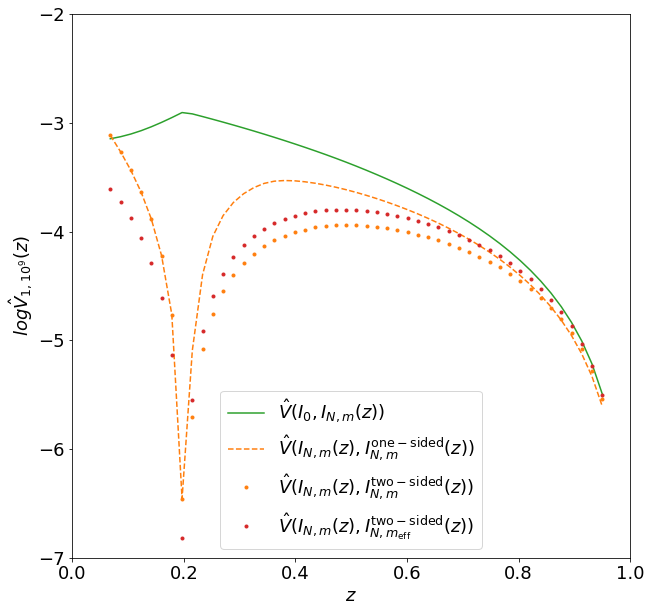

In [16]:

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

mpl.rc('font', **font)    

f, axes = plt.subplots(1, 1, figsize=(10, 10), sharex=False, sharey=False)


plt.plot(zls[1:],np.log10(sqrmeanmean[1:]) , 'C2-',label='$\hat{V}(I_0,I_{N,m}(z))$')
plt.plot(zls[1:],np.log10(sqrmeanmean1[1:]) , 'C1--',label='$\hat{V}(I_{N,m}(z),I^{\mathrm{one-sided}}_{N,m}(z))$')
plt.plot(zls[1:],np.log10(sqrmeanmean2[1:]) , 'C1.',label='$\hat{V}(I_{N,m}(z),I^{\mathrm{two-sided}}_{N,m}(z))$')
plt.plot(zls[1:],np.log10(sqrmeanmean6[1:]) , 'C3.',label='$\hat{V}(I_{N,m}(z),I^{\mathrm{two-sided}}_{N,m_\mathrm{eff}}(z))$')

plt.xlabel('$z$')
plt.ylabel('$log \hat{V}_{1,10^9}(z)$')
plt.xlim(0,1)
plt.ylim(-7,-2)
#axes.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2e'))
#plt.xscale('log')
#plt.yscale('log')
plt.legend()
plt.show()

0.05


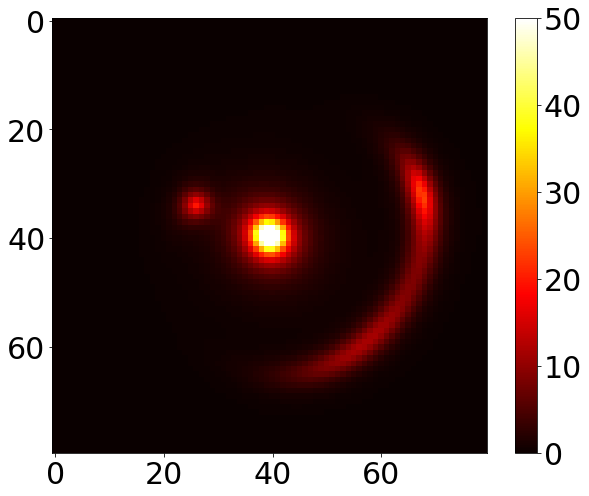

0.06836734693877551


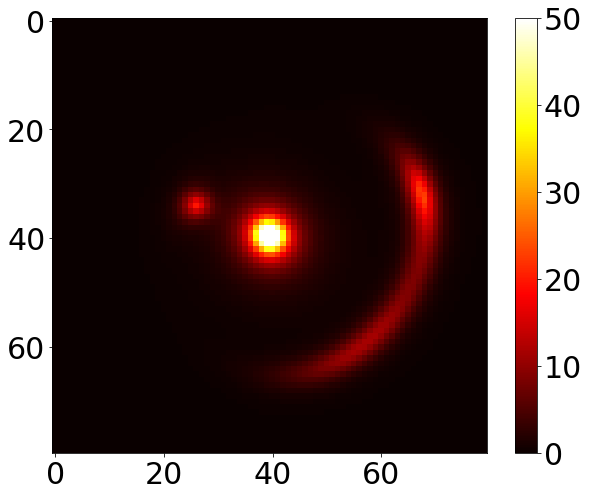

0.08673469387755102


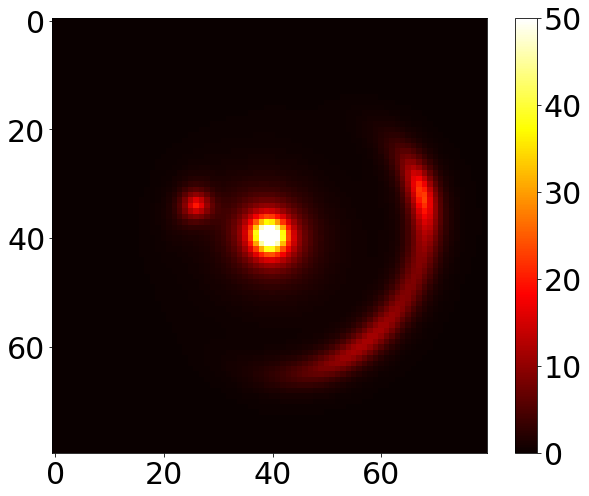

0.10510204081632653


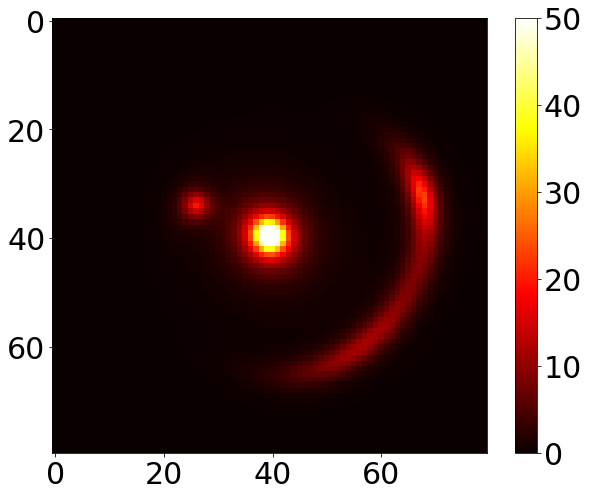

0.12346938775510204


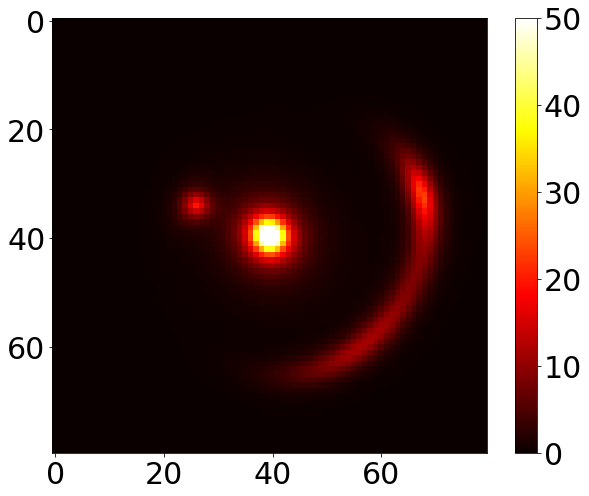

0.14183673469387753


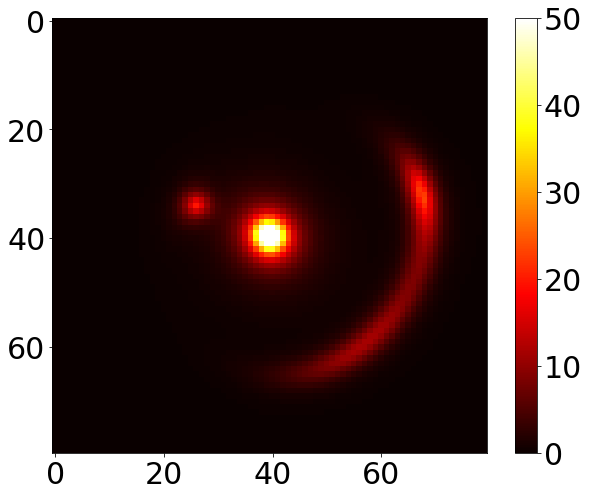

0.16020408163265304


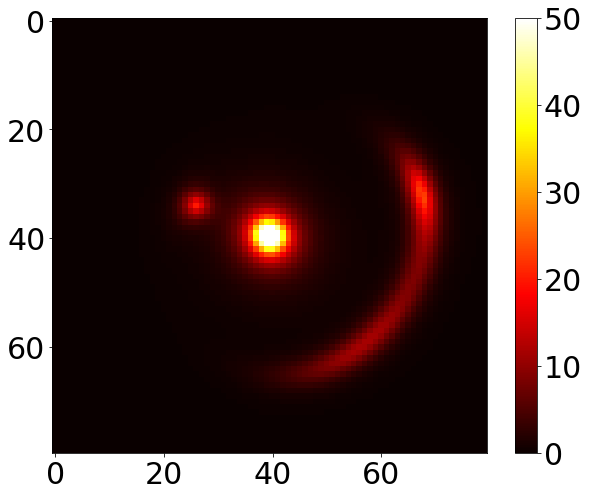

0.17857142857142855


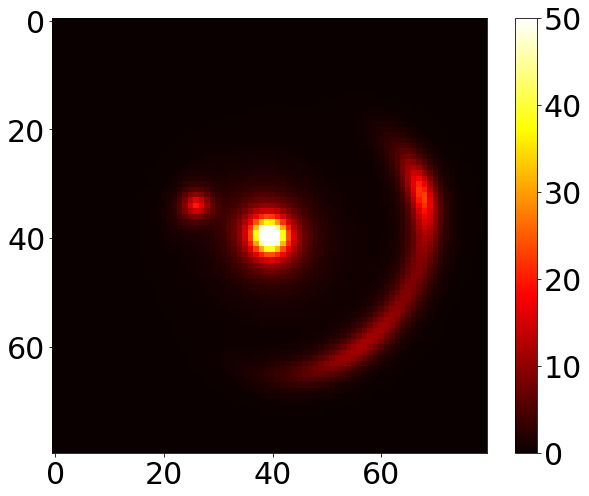

0.19693877551020406


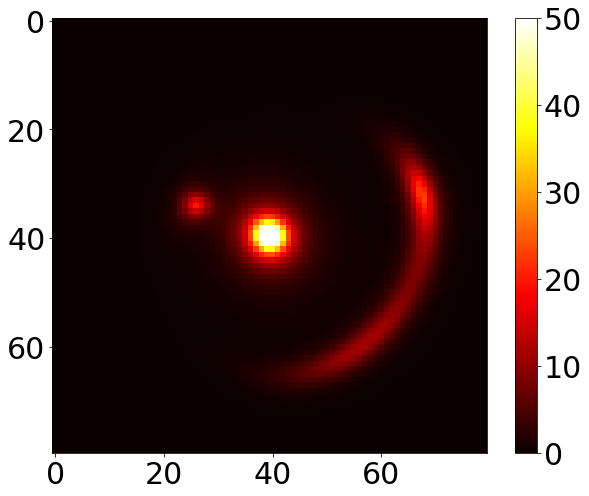

0.21530612244897956


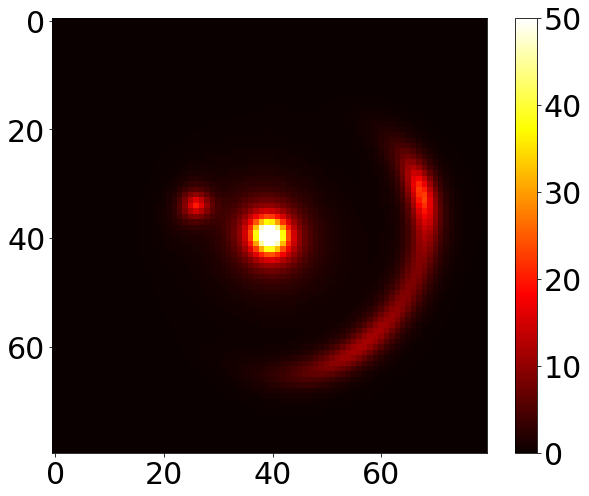

0.23367346938775507


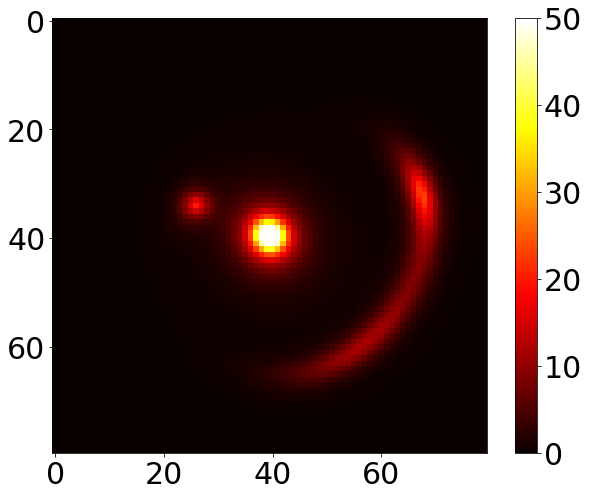

0.2520408163265306


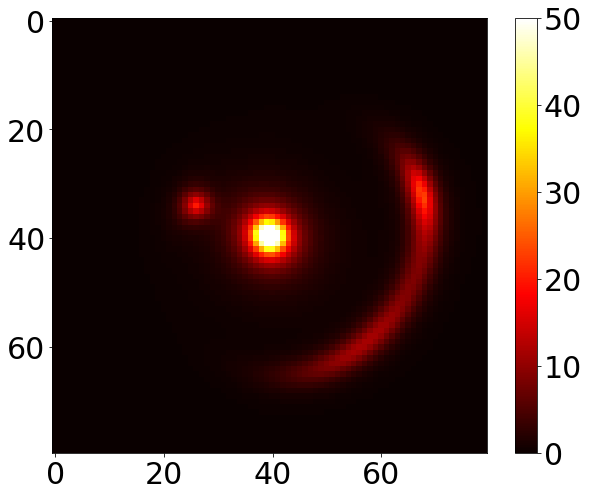

0.2704081632653061


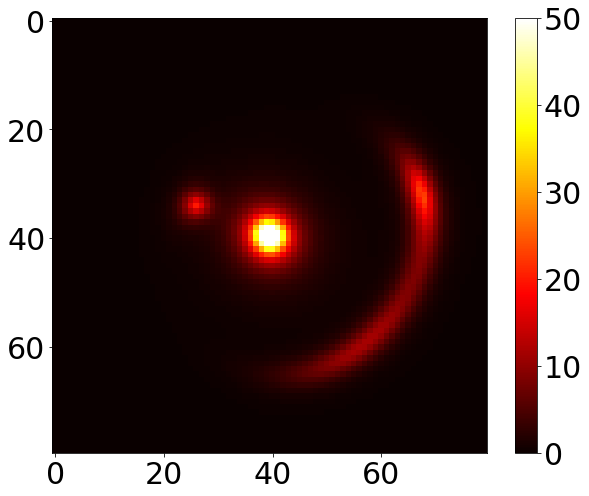

0.2887755102040816


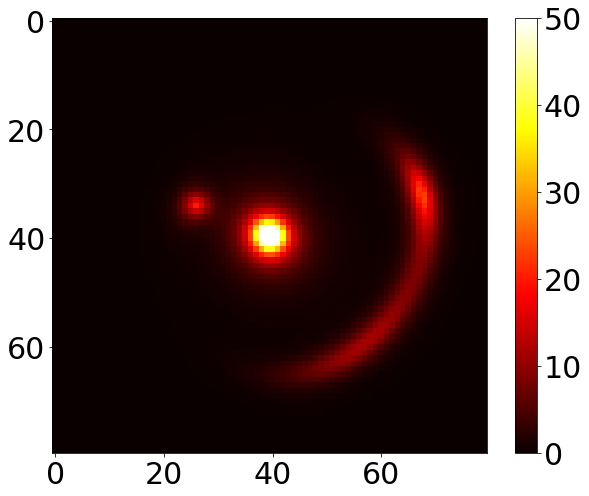

0.3071428571428571


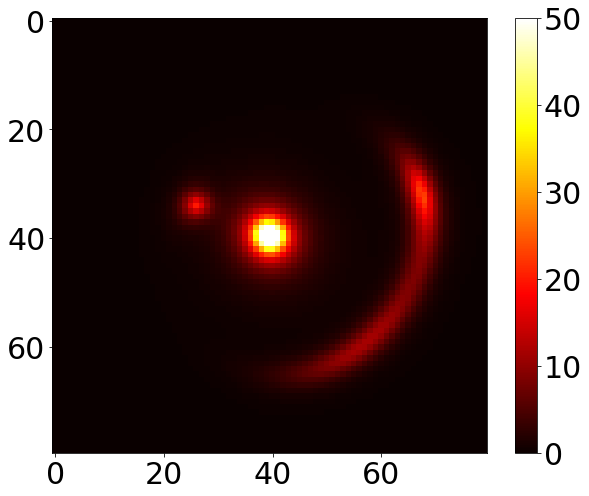

0.3255102040816326


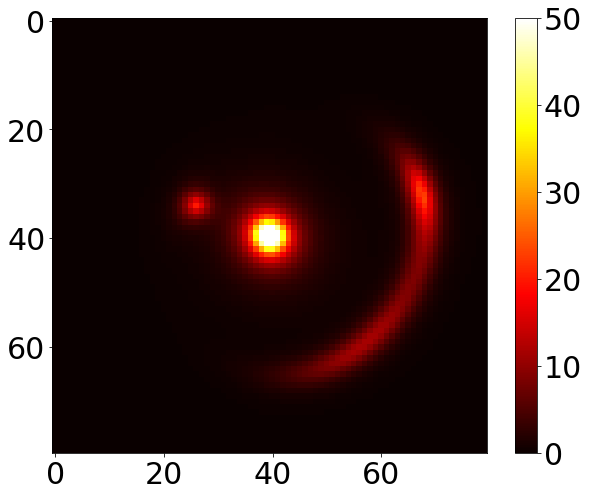

0.3438775510204081


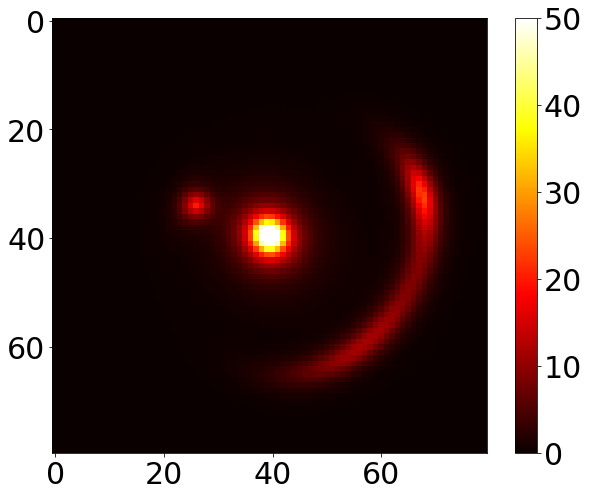

0.36224489795918363


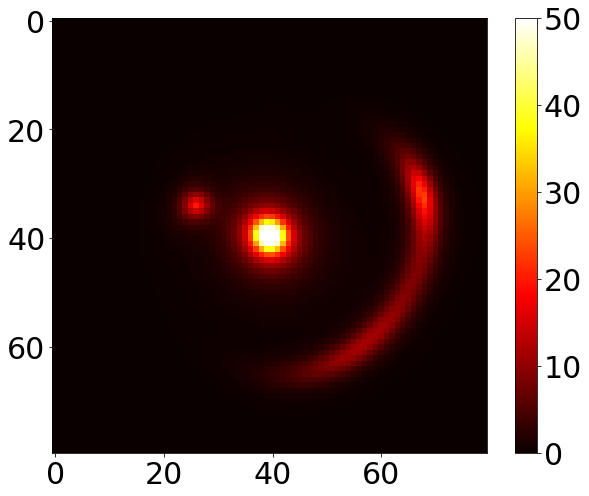

0.38061224489795914


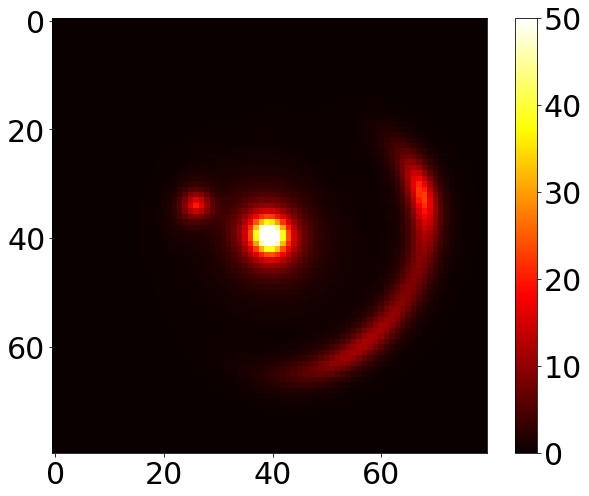

0.39897959183673465


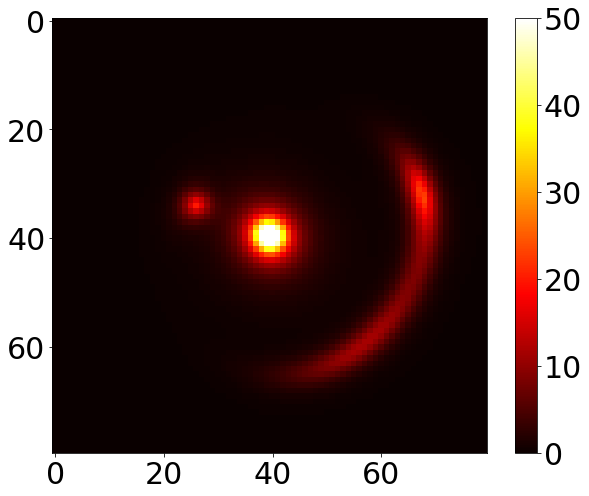

0.41734693877551016


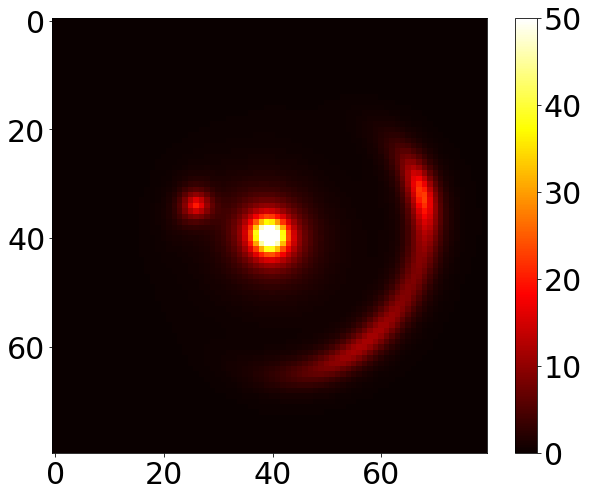

0.43571428571428567


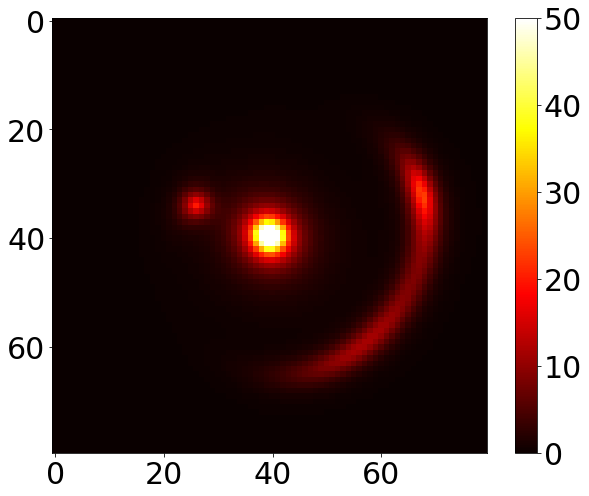

0.4540816326530612


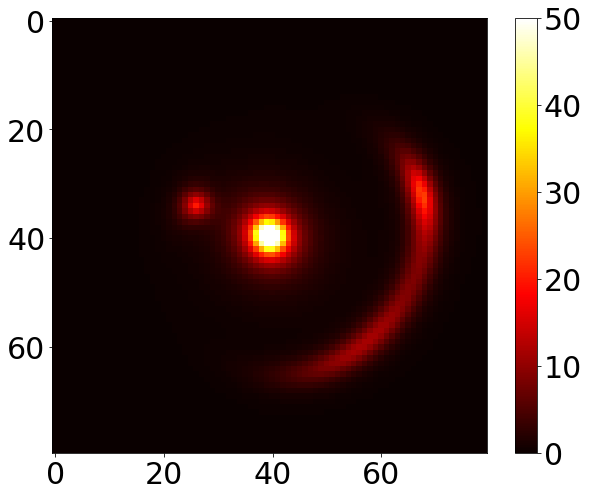

0.4724489795918367


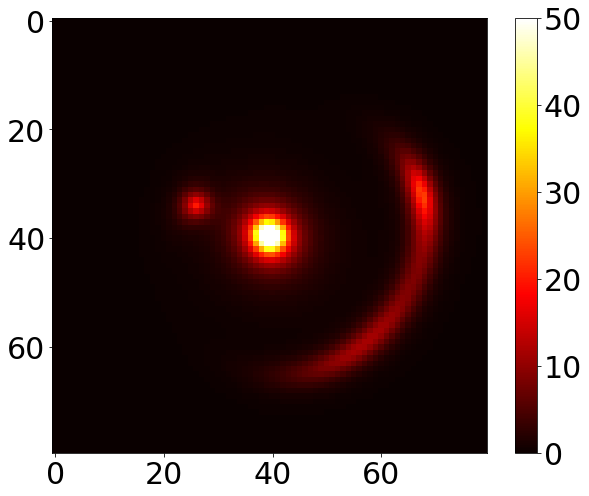

0.4908163265306122


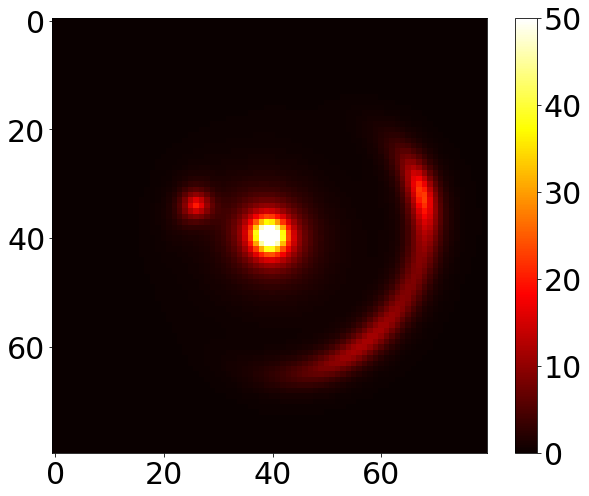

0.5091836734693878


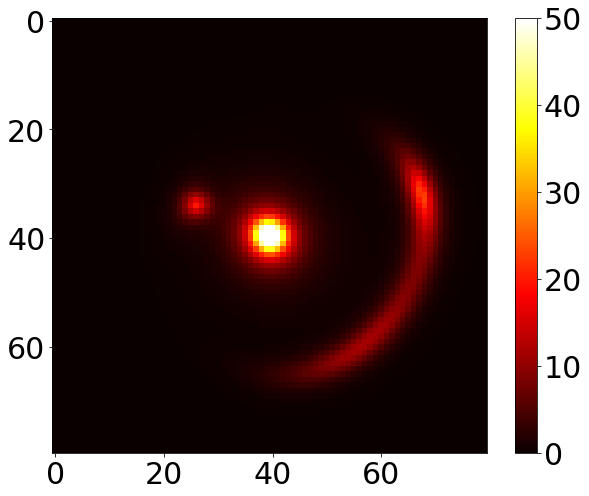

0.5275510204081633


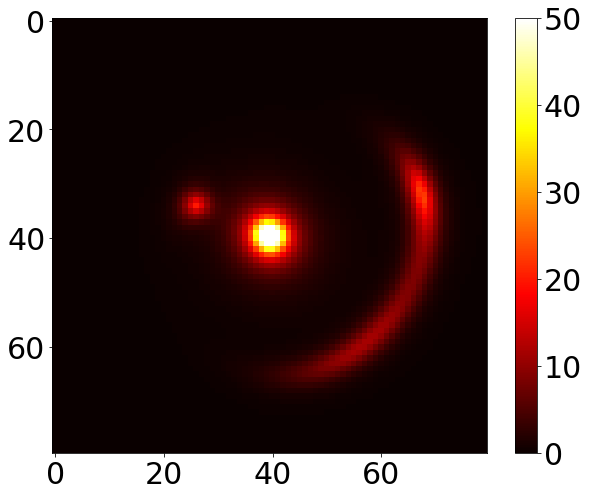

0.5459183673469388


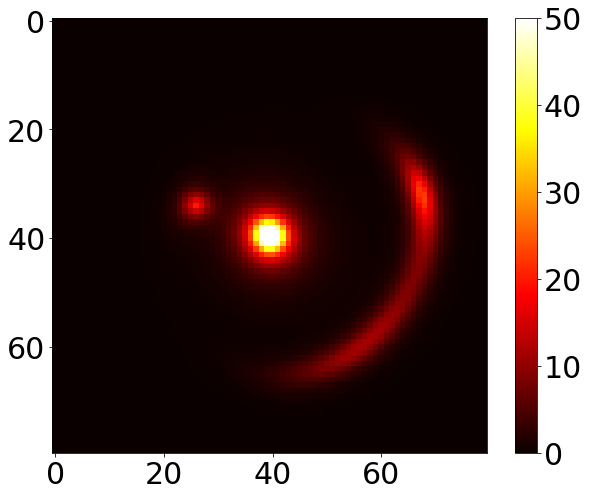

0.5642857142857143


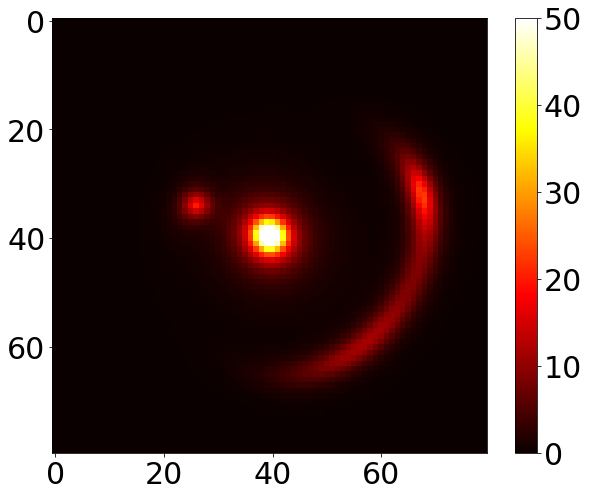

0.5826530612244898


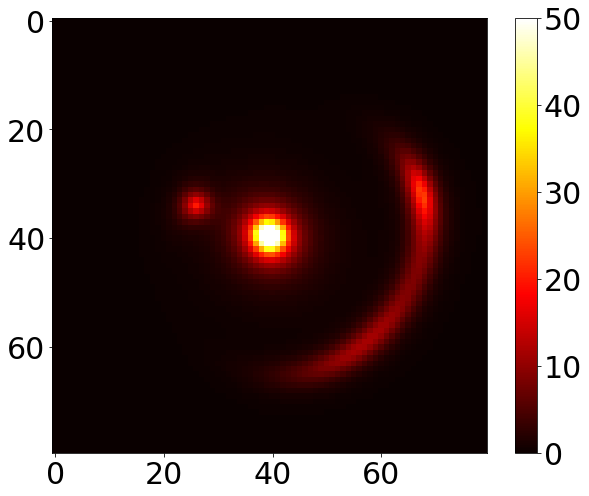

0.6010204081632653


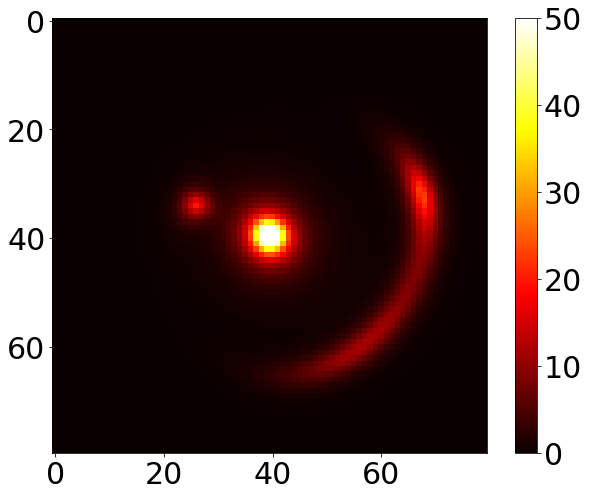

0.6193877551020408


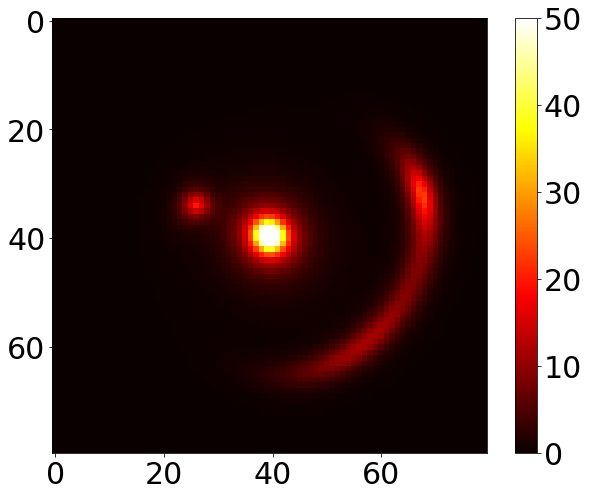

0.6377551020408163


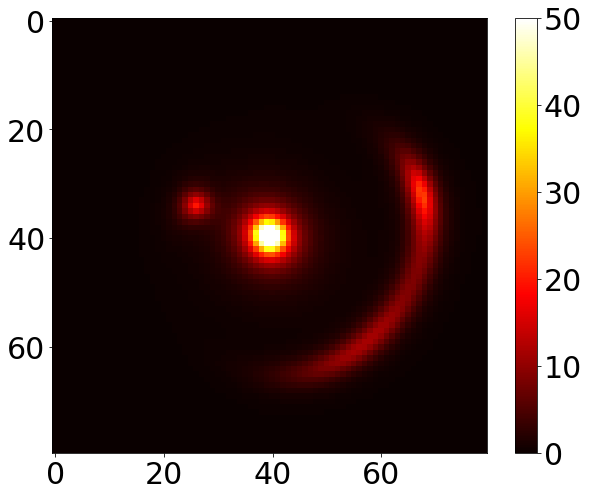

0.6561224489795918


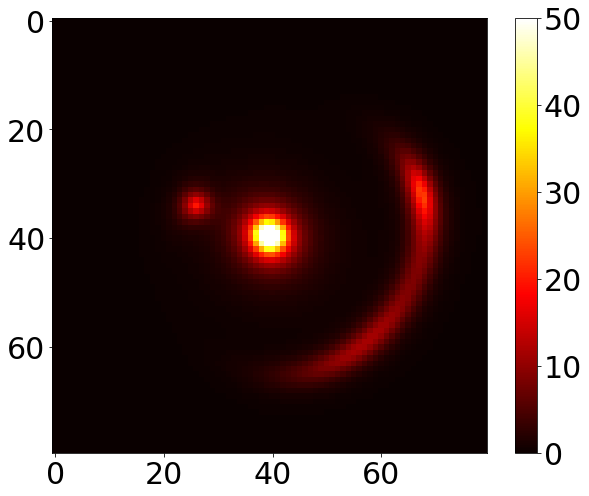

0.6744897959183673


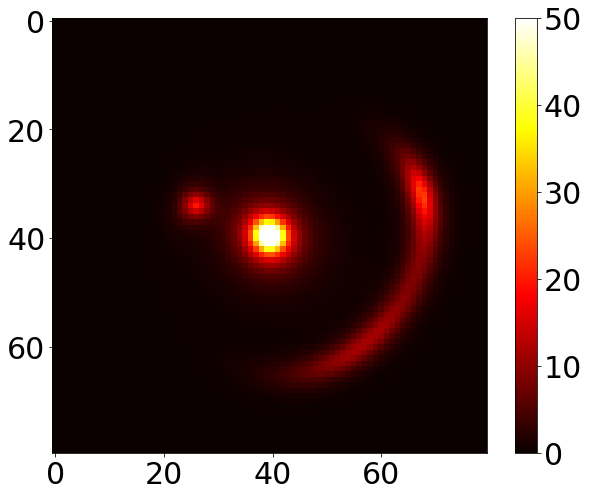

0.6928571428571428


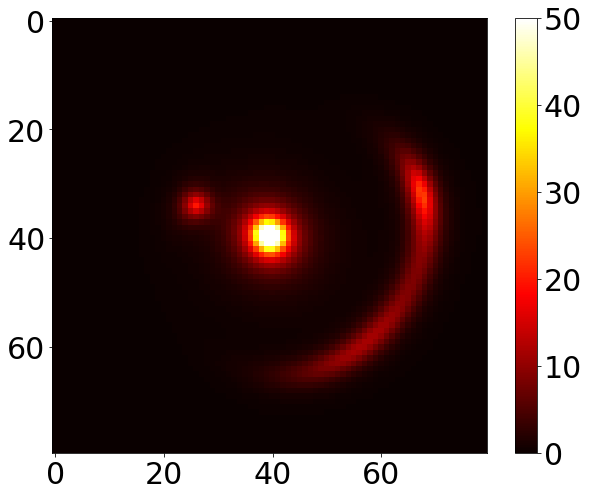

0.7112244897959183


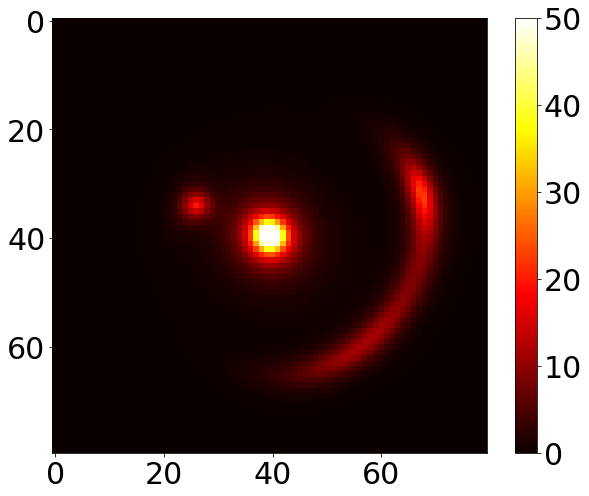

0.7295918367346939


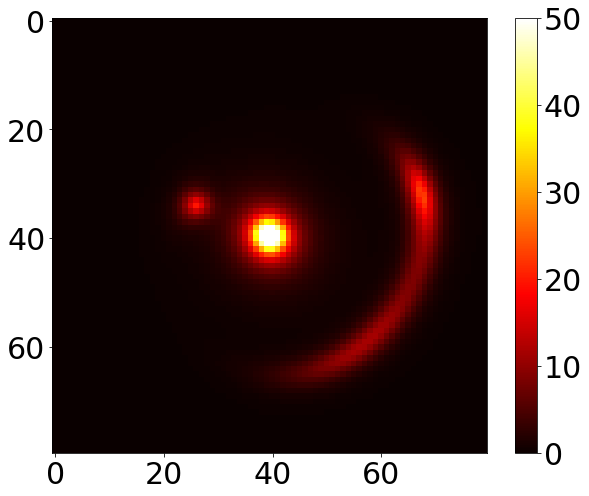

0.7479591836734694


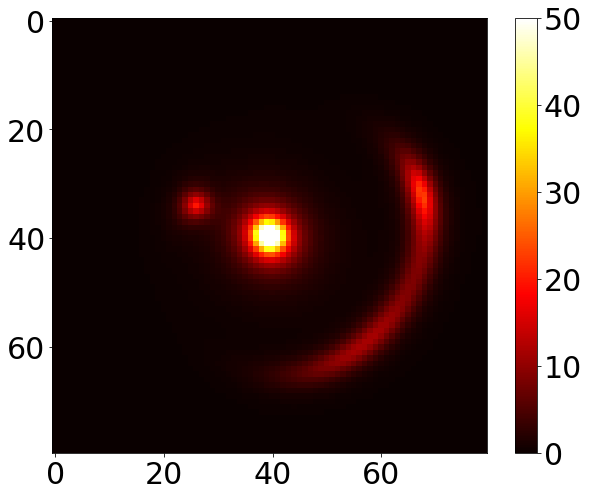

0.7663265306122449


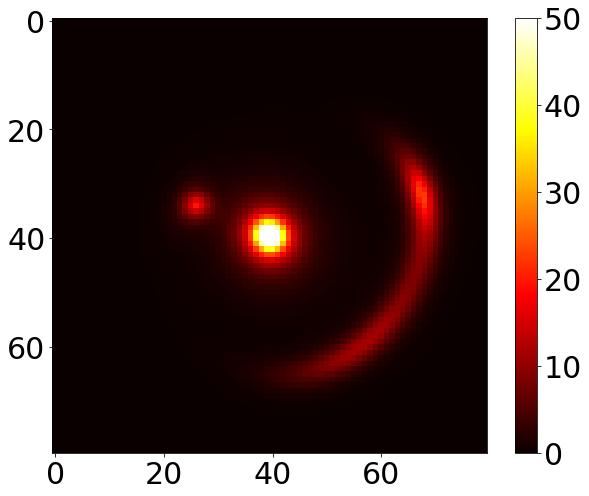

0.7846938775510204


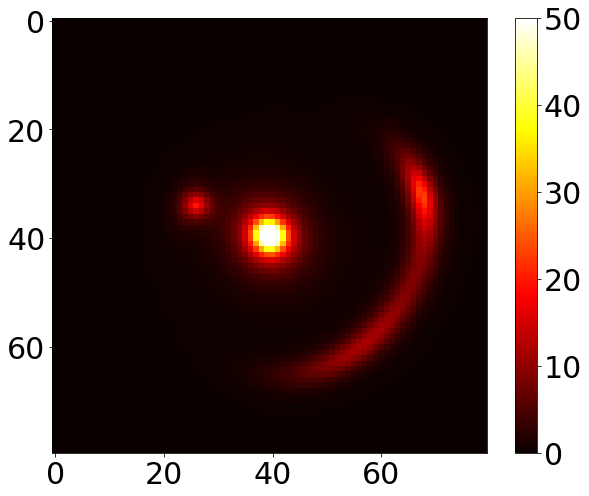

0.8030612244897959


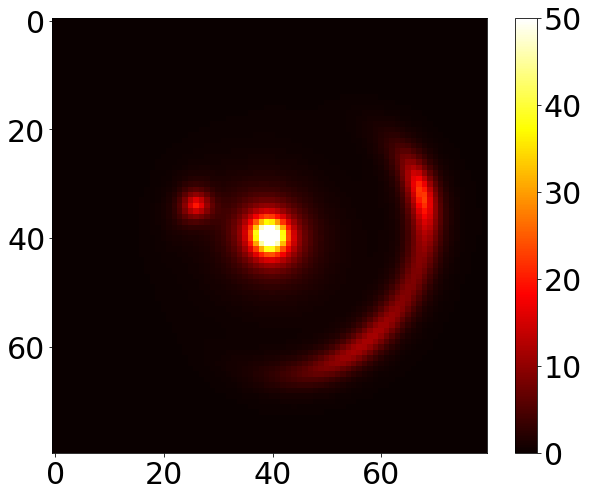

0.8214285714285714


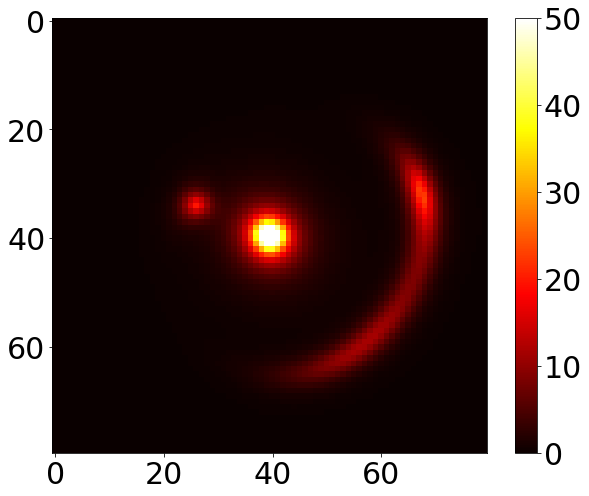

0.8397959183673469


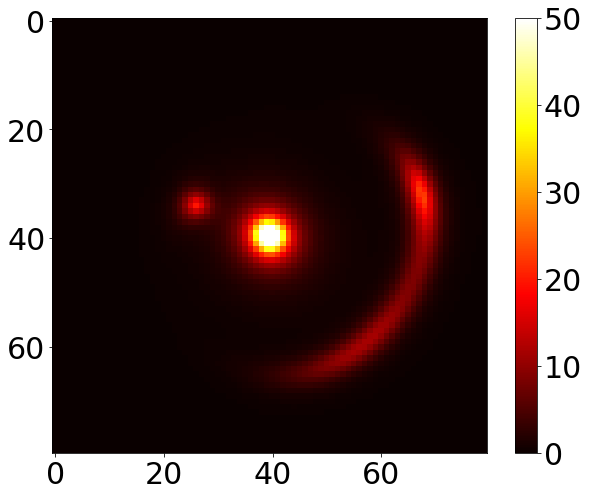

0.8581632653061224


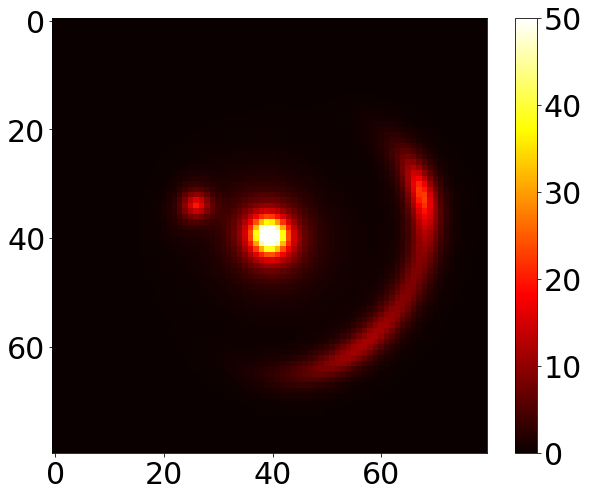

0.8765306122448979


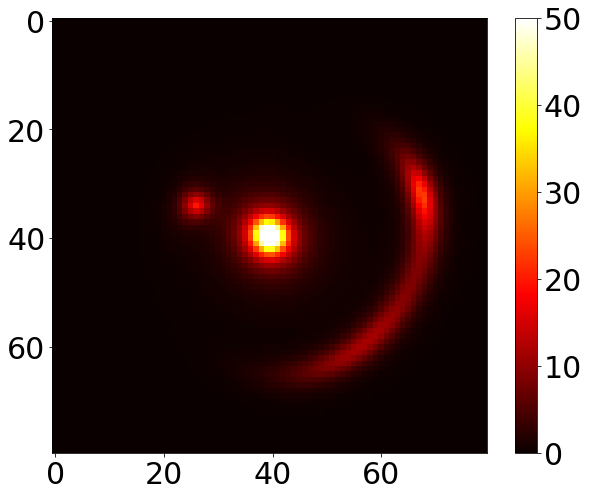

0.8948979591836734


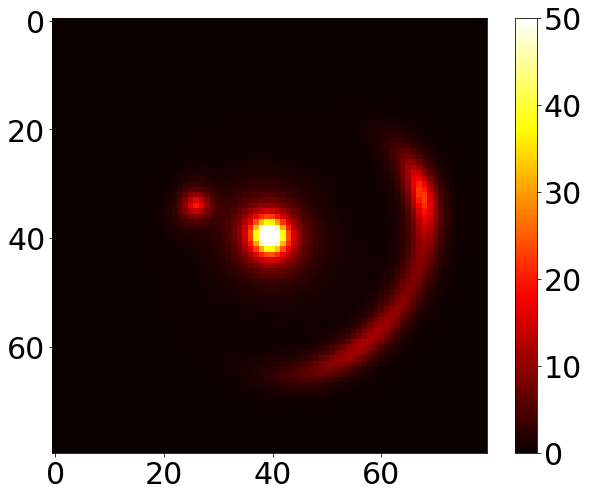

0.9132653061224489


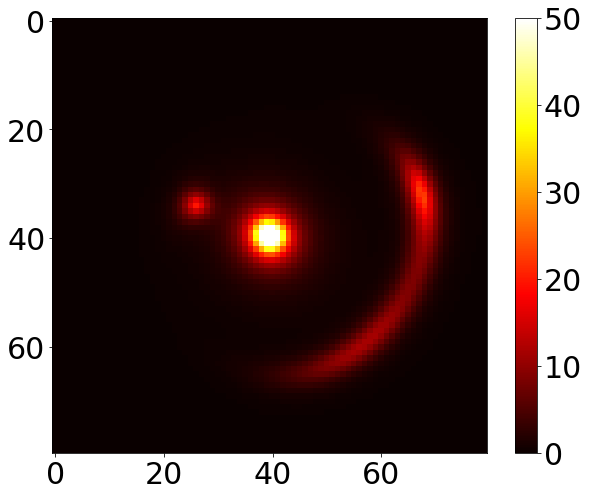

0.9316326530612244


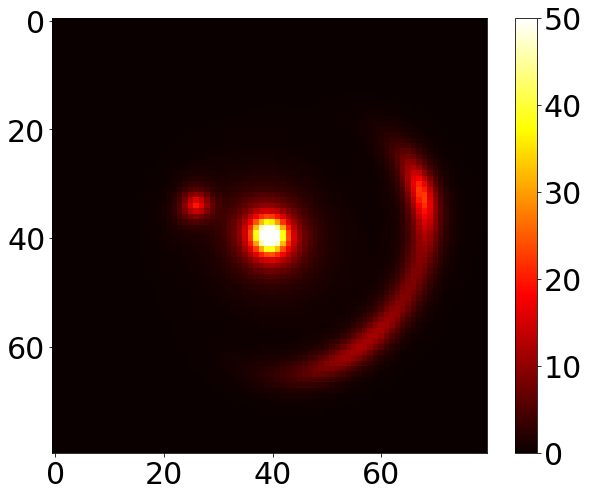

0.95


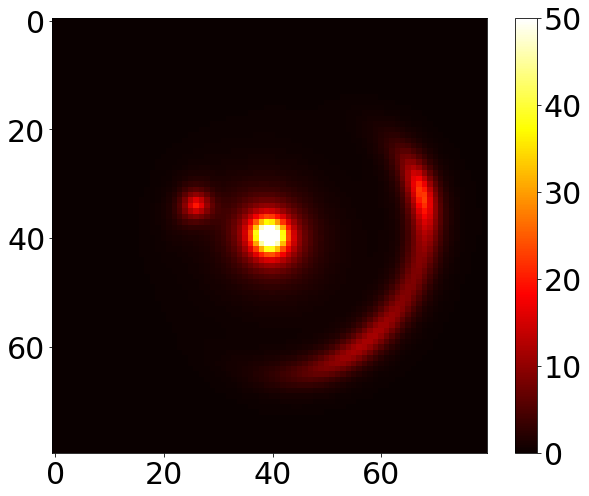

In [76]:
orig_cmap = cms.hot

for i in range(Nit):
    print(zls[i])
    f, axes = plt.subplots(1, 1, figsize=(10, 8), sharex=False, sharey=False)
    pos = axes.imshow(imagesz[i][0], cmap=orig_cmap, interpolation='nearest',vmin=0.,vmax=50.)
    f.colorbar(pos, ax=axes)
    plt.show()

# add the colorbar using the figure's method,
# telling which mappable we're talking about and
# which axes object it should be near
